In [1]:
# --- Auto-reload packages when code changes (no kernel restart needed) ---
try:
    # For Jupyter/IPython environments
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
    print("🔄 Autoreload enabled: code changes will be auto-reloaded!")
except Exception as e:
    print("⚠️ Could not enable autoreload (not in IPython/Jupyter?):", e)


🔄 Autoreload enabled: code changes will be auto-reloaded!


In [15]:
# Clean solution: Auto-add project root to path
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['image.cmap'] = 'cividis'


# Get the project root (parent directory of examples/)
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now import everything cleanly
from DynaSD import GIN, NDD, LiNDDA, MINDD, IMPRINT, WVNT

import numpy as np
import pandas as pd
import scipy as sc

from tests.synthetic_data_generator import SyntheticSeizureGenerator

print("✅ DynaSD imported successfully!")
print(f"📁 Project root: {project_root}")
print(f"🐍 Using Python: {sys.executable}")

# Verify the imports work
print(f"📦 GIN class: {GIN}")
print(f"📦 NDD class: {NDD}")

✅ DynaSD imported successfully!
📁 Project root: /Users/wojemann/Documents/CNT/DynaSD
🐍 Using Python: /Users/wojemann/Documents/CNT/DynaSD/dynasd_env/bin/python
📦 GIN class: <class 'DynaSD.GIN.GIN'>
📦 NDD class: <class 'DynaSD.NDD.NDD'>


In [3]:
fs = 256
generator = SyntheticSeizureGenerator(fs=fs, random_seed=42)

data,sz_start,sz_end = generator.generate_combined_signal(baseline_duration=20, seizure_duration=10, seizure_type='spike_wave', n_channels=16, focal_channels=list(range(8)), transition_duration=0)


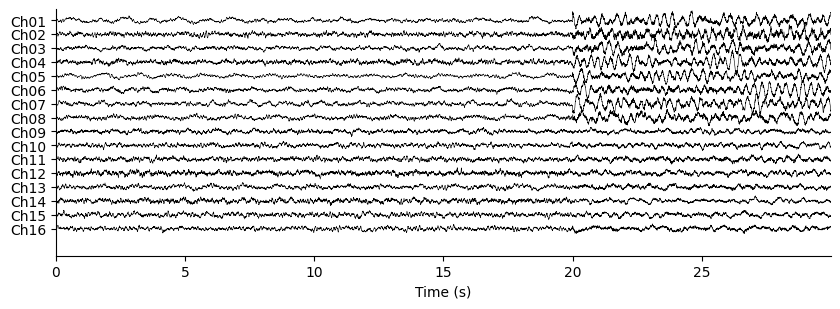

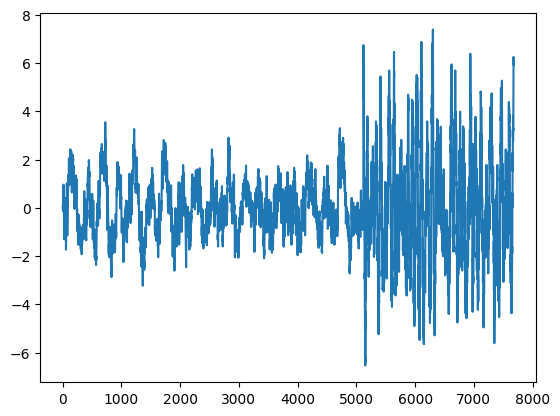

In [4]:
from example_utils import plot_iEEG_data

plot_iEEG_data(data,fs=fs)
plt.show()
plt.plot(data[['Ch01']])
plt.show()

In [105]:
# model = GIN(num_epochs=100,batch_size=32,sequence_length = 128,forecast_length=32,hidden_size=256,early_stopping=True, num_layers=2,lr=0.0005,w_stride=0.25,w_size=1,patience=3)
model = LiNDDA(num_epochs=200,batch_size=32,sequence_length = 128,forecast_length=32,early_stopping=True,lr=0.0005,w_stride=0.25,w_size=1)
# model = MINDD(num_epochs=100,batch_size=32,sequence_length = 128,forecast_length=32,early_stopping=True,lr=0.0005,dropout=0.5,hidden_sizes=[128*data.shape[1]],w_stride=0.25,w_size=1,patience=3)
model.fit(data.iloc[:fs*10,:])

  Model: LinearForecaster_16ch_128seq
  Parameters: 32,784
Training LinearForecaster model:
  Sequence length: 128, Forecast length: 1
  Early stopping: True
Creating 2432 non-overlapping sequences from continuous data
  Created 2432 sequences
  Training sequences: 1946, Validation sequences: 486
Starting training...


Training:  22%|██▏       | 43/200 [00:02<00:08, 19.57it/s, train_loss=0.0344, val_loss=0.1148, patience=5]


Early stopping triggered after 44 epochs
Training completed


Creating 236 non-overlapping sequences from continuous data


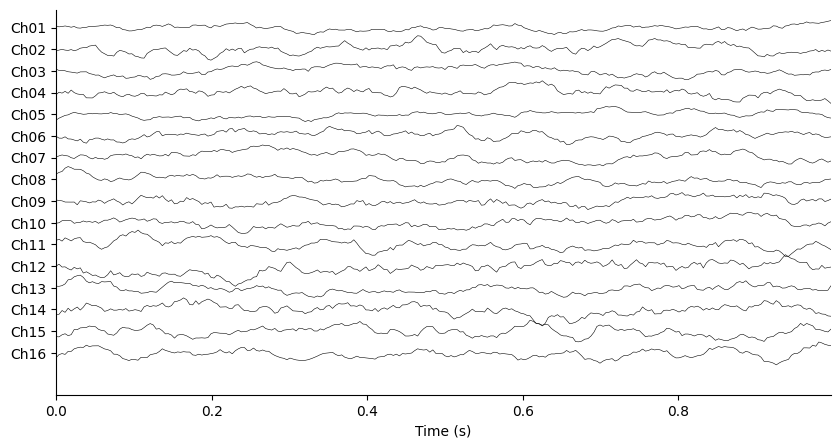

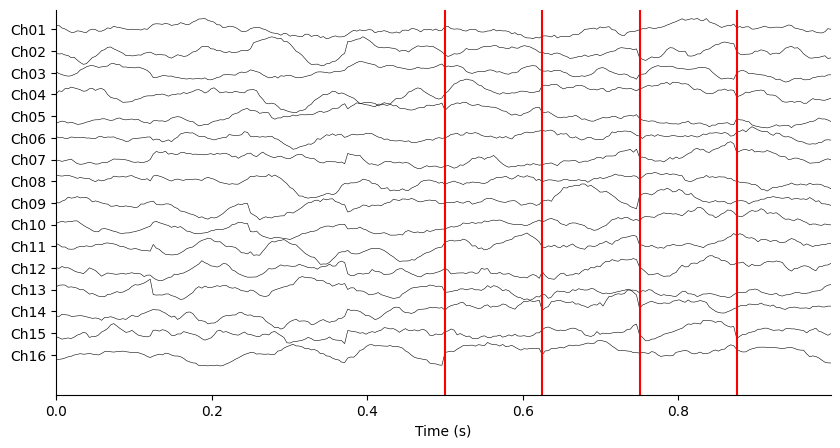

In [114]:
x = model.predict(data.iloc[:,:])
s = 10*fs
plot_iEEG_data(data.iloc[s:s+256,:],fs=fs,fig_size=(10,5))
plt.show()
fig,ax = plot_iEEG_data(pd.DataFrame(x,columns=data.columns).iloc[s:s+256,:],fs=fs,fig_size=(10,5))
for v in range(5):
    ax.axvline((v*32+128)/fs,color='r')
plt.show()

Creating 236 non-overlapping sequences from continuous data


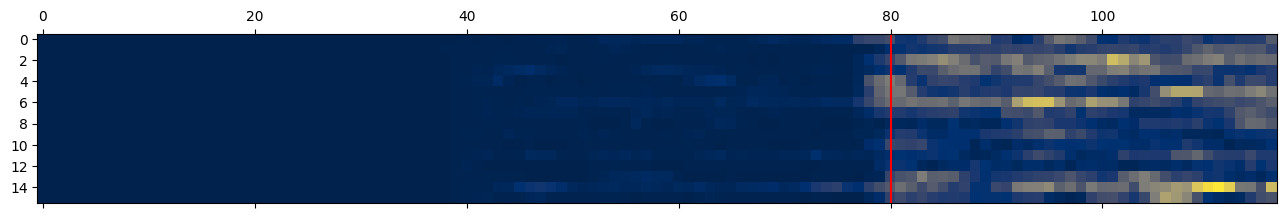

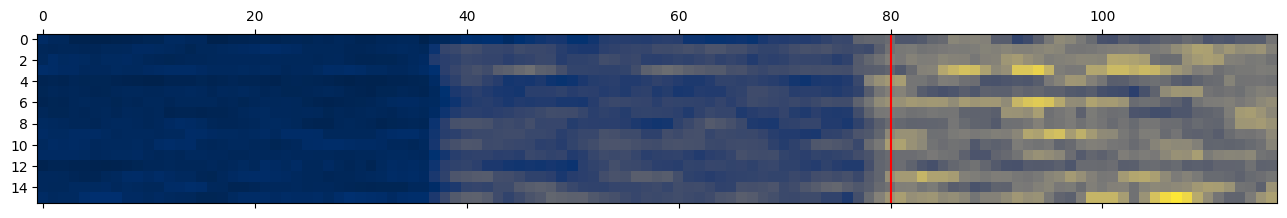

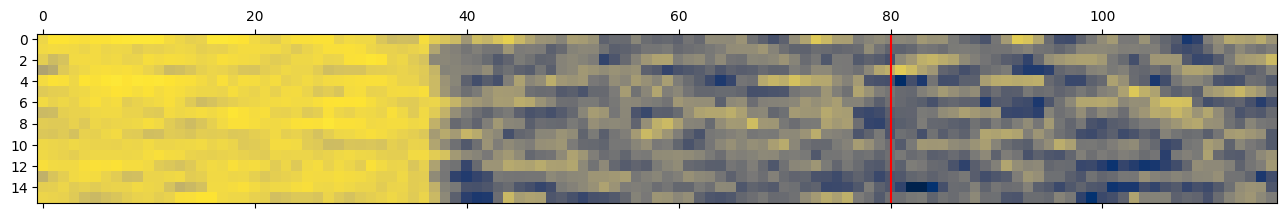

Creating 236 non-overlapping sequences from continuous data


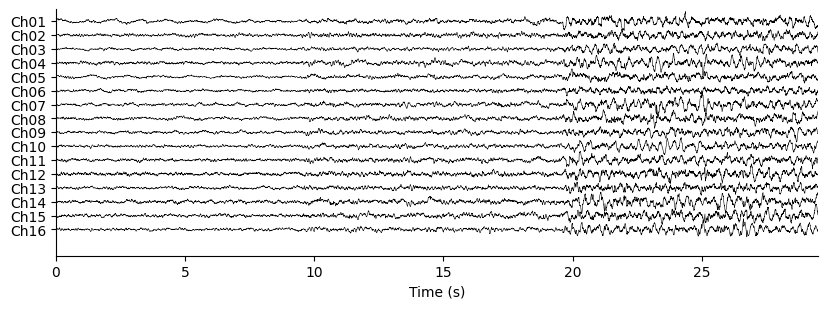

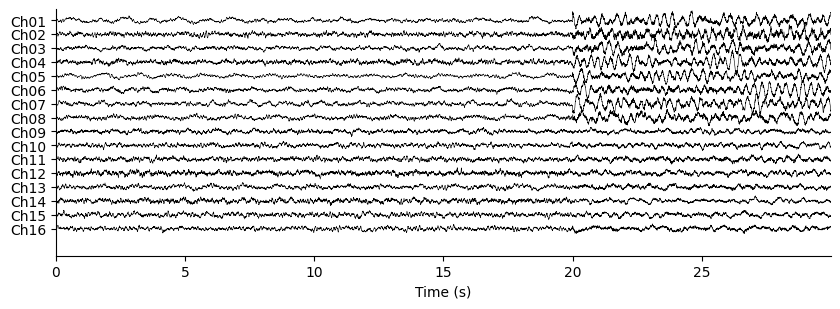

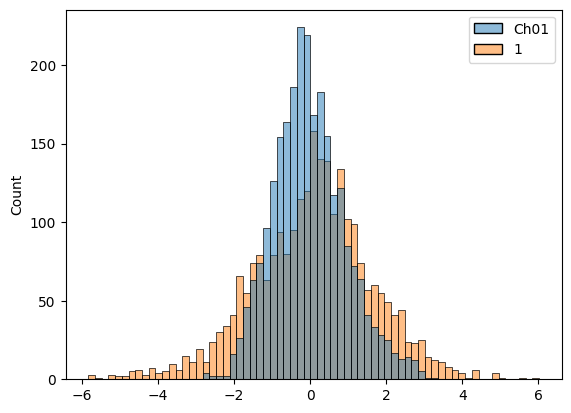

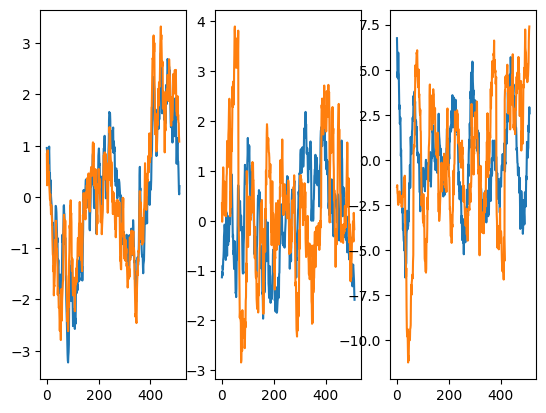

In [107]:
prob_times = model.get_win_times(len(data))
onset_idx = np.argmin(np.abs(prob_times-sz_start))//2
mse,corr = model(data)

mse = mse.to_numpy()
corr = corr.to_numpy()
XY = np.concatenate((mse.reshape(mse.shape[0],mse.shape[1],1),corr.reshape(corr.shape[0],corr.shape[1],1)),axis=2).transpose(1,0,2)
# XY = mse.reshape(mse.shape[0],mse.shape[1],1).transpose(1,0,2)
X = XY[:,:onset_idx,:]
Y = XY[:,onset_idx:,:]
mahalanobis = np.zeros(corr[:,:].shape)
for i in range(X.shape[0]):
    x = X[i,:,:].reshape(-1,X.shape[2])
    y = XY[i,:,:].reshape(-1,XY.shape[2])
    m = np.mean(x, axis=0)
    C = x - m
    Q, R = np.linalg.qr(C) 
    ri = np.linalg.solve(R.T, (y - m).T)
    mahalanobis[:,i] = np.sum(ri * ri, axis=0) * (x.shape[0] - 1)

for mat in [mahalanobis,mse,corr]:
    plt.matshow(mat.T)
    # plt.colorbar()
    plt.axvline(x=onset_idx*2,color='r')
    plt.show()

x = model.predict(data)
plot_iEEG_data(pd.DataFrame(x,columns=data.columns).loc[np.isnan(x).sum(axis=1)==0,:],fs=fs)
plot_iEEG_data(data,fs=fs)
plt.show()

sns.histplot((data['Ch01'][10*fs:20*fs],x[10*fs:20*fs,0]))
plt.show()
s = 5*fs
plt.subplot(1,3,1)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
s = 15*fs
plt.subplot(1,3,2)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
s = 20*fs
plt.subplot(1,3,3)
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])
plt.show()


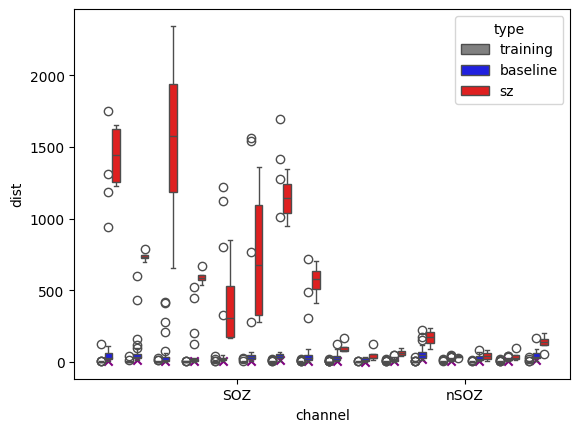

In [73]:
train_mask = (prob_times <= 10)
train_df = pd.DataFrame(mahalanobis[train_mask],columns=data.columns)
gen_mask = (prob_times <= sz_start) & (prob_times > 10)
gen_df = pd.DataFrame(mahalanobis[gen_mask],columns=data.columns)
sz_mask = (prob_times <= sz_start+1) & (prob_times > sz_start)
sz_df = pd.DataFrame(mahalanobis[sz_mask],columns=data.columns)
train_df['type'] = 'training'
gen_df['type'] = 'baseline'
sz_df['type'] = 'sz'
df = pd.concat([train_df,gen_df,sz_df])
df = df.melt(id_vars=['type'],var_name='channel',value_name='dist')
sns.boxplot(data=df,x='channel',y='dist',hue='type',palette=['gray','blue','red'])
plt.scatter(list(range(gen_df.shape[1]-1)), gen_df.iloc[:,:-1].quantile(0.05),color='purple',marker='x')
plt.xticks([4.5,12.5],['SOZ','nSOZ'])
plt.show()

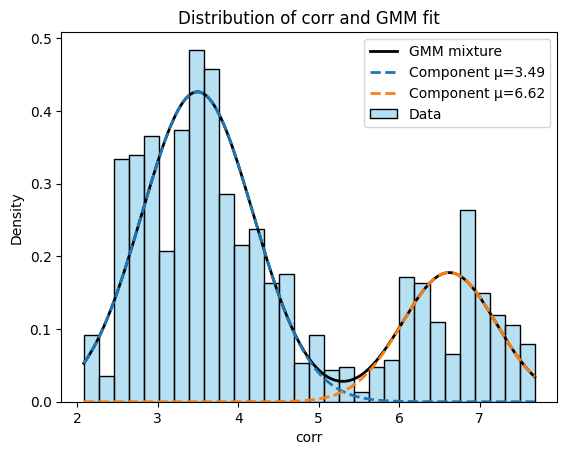

In [76]:
from sklearn.mixture import GaussianMixture
x = sc.ndimage.median_filter(np.log(mahalanobis[~train_mask,:].copy()),size=20,mode='nearest',axes=0)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(x.reshape(-1,1))

import numpy as np

# Plot the histogram of the data
sns.histplot(x.flatten(), bins=30, stat='density', color='skyblue', label='Data', alpha=0.6)

# Plot the estimated Gaussian components
x = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)  # Score for each x, repeated for 8 channels
pdf = np.exp(logprob)
plt.plot(x, pdf, color='black', lw=2, label='GMM mixture')

# Plot each component
means = gmm.means_.flatten()
covars = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_.flatten()
for mean, covar, weight in zip(means, covars, weights):
    component_pdf = weight * (1/(np.sqrt(2*np.pi)*covar)) * np.exp(-0.5*((x-mean)/covar)**2)
    plt.plot(x, component_pdf, lw=2, linestyle='--', label=f'Component μ={mean:.2f}')

plt.legend()
plt.xlabel('corr')
plt.ylabel('Density')
plt.title('Distribution of corr and GMM fit')
plt.show()

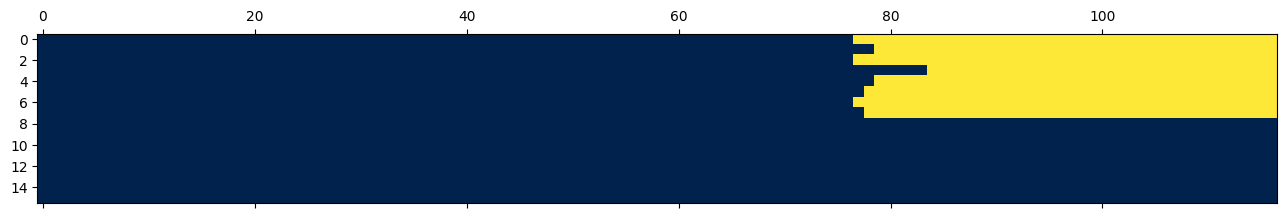

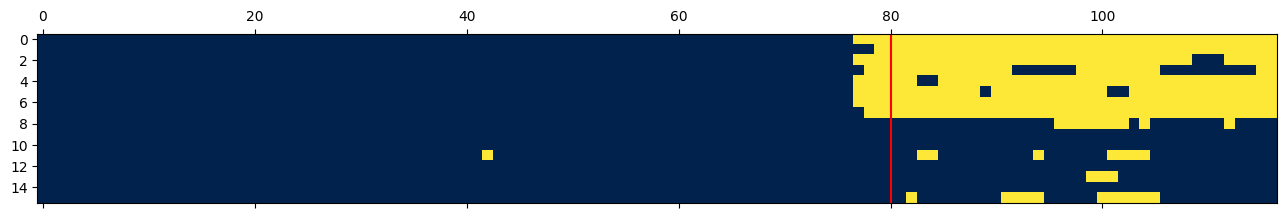

In [81]:
plt.matshow(sc.ndimage.median_filter(mahalanobis,size=40,mode='nearest',axes=0).T>np.exp(5.3))
plt.matshow(mahalanobis.T>np.exp(5.3))

plt.axvline(x=onset_idx*2,color='r')
plt.show()

tensor(0.3721)